In [1]:
import numpy as np
import torch
import sys
sys.path.append('../')
from model import Model
from loss import loss_cosine_similarity
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
model_eigenvectors = torch.jit.load("../models/eigenvectors_cosine_similarity_skip1_batch64_modelstandard_actrelu.pt")
model_simulation = torch.jit.load("../models/simulation_cosine_similarity_skip10_batch64_modelstandard_actrelu.pt")

In [3]:
grid_size_x = 34
grid_size_y = 34
dx = 1 / (grid_size_x)
dy = 1 / (grid_size_y)
dx2 = dx ** 2
dy2 = dy ** 2

# generate Matrix A which is the discretized Laplacian in 2D
A = np.zeros((grid_size_x * grid_size_y, grid_size_x * grid_size_y))
for i in range(grid_size_x):
    for j in range(grid_size_y):
        row = i * grid_size_y + j
        A[row, row] = -2 * (1 / dx2 + 1 / dy2)
        if i > 0:
            A[row, row - grid_size_y] = 1 / dx2
        if i < grid_size_x - 1:
            A[row, row + grid_size_y] = 1 / dx2
        if j > 0:
            A[row, row - 1] = 1 / dy2
        if j < grid_size_y - 1:
            A[row, row + 1] = 1 / dy2

A_inverse = np.linalg.inv(A)

In [4]:
loss_eigenvectors = []
loss_simulation = []
for i in tqdm(range(1000)):
    input_vector = np.loadtxt(f"../data/simulation_data/res_{i}.dat")
    true_vector = input_vector.flatten().dot(A_inverse)
    input_vector = torch.tensor(input_vector).float().unsqueeze(0).unsqueeze(0).to('cuda')
    true_vector = torch.tensor(true_vector).float().unsqueeze(0).unsqueeze(0).to('cuda')
    pred_eigenvector = model_eigenvectors(input_vector)
    pred_simulation = model_simulation(input_vector)
    loss_eigenvectors.append(loss_cosine_similarity(pred_eigenvector, true_vector, 1, 34, 34).item())
    loss_simulation.append(loss_cosine_similarity(pred_simulation, true_vector, 1, 34, 34).item())
    # free gpu memory
    del input_vector
    del true_vector

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [02:40<00:00, 62.16it/s] 


In [5]:
print(loss_eigenvectors)

[0.014692813158035278, 0.0062142908573150635, 0.018543392419815063, 0.019528090953826904, 0.007983028888702393, 0.01789027452468872, 0.02354934811592102, 0.012537121772766113, 0.006229519844055176, 0.0127602219581604, 0.019957304000854492, 0.014863431453704834, 0.015492796897888184, 0.03828439116477966, 0.011374503374099731, 0.00639951229095459, 0.013526082038879395, 0.021593749523162842, 0.019500941038131714, 0.019566237926483154, 0.041798949241638184, 0.010060340166091919, 0.006492584943771362, 0.013274699449539185, 0.022742390632629395, 0.021903246641159058, 0.021045714616775513, 0.04234945774078369, 0.009348124265670776, 0.0067059993743896484, 0.013207435607910156, 0.023374557495117188, 0.022398561239242554, 0.0210534930229187, 0.04127049446105957, 0.008955121040344238, 0.006945431232452393, 0.013080298900604248, 0.02413758635520935, 0.022510677576065063, 0.02150920033454895, 0.04066503047943115, 0.008674204349517822, 0.007162809371948242, 0.013036012649536133, 0.02472350001335144,

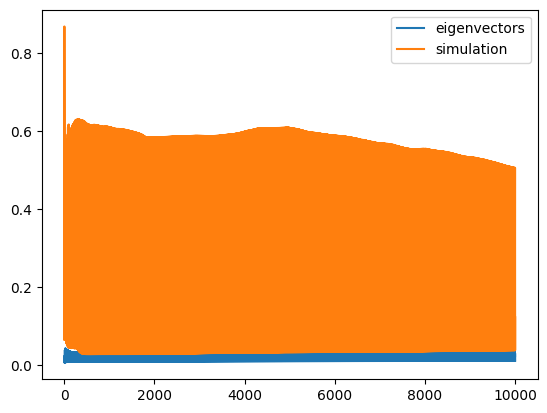

In [6]:
# plot loss
plt.plot(loss_eigenvectors, label='eigenvectors')
plt.plot(loss_simulation, label='simulation')
plt.legend()
plt.show()

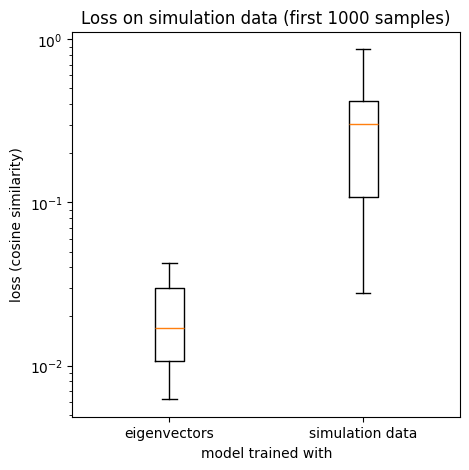

In [13]:
test_loss_eigenvectors = np.mean(loss_eigenvectors)
test_loss_simulation = np.mean(loss_simulation)
std_loss_eigenvectors = np.std(loss_eigenvectors)
std_loss_simulation = np.std(loss_simulation)

# plot boxplot
plt.figure(figsize=(5, 5))
plt.boxplot([loss_eigenvectors, loss_simulation], labels=['eigenvectors', 'simulation data'])
plt.xlabel('model trained with')
plt.ylabel('loss (cosine similarity)')
plt.title('Loss on simulation data (first 1000 samples)')
plt.yscale('log')
plt.savefig('test_loss_sim.pdf', format='pdf')